# 05 - Taming Text

## Deadline
Thursday December 15, 2016 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution
you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code

## Background
In this homework you will explore a relatively large corpus of emails released in public during the
[Hillary Clinton email controversy](https://en.wikipedia.org/wiki/Hillary_Clinton_email_controversy).
You can find the corpus in the `hillary-clinton-emails` directory of this repository, while more detailed information 
about the [schema is available here](https://www.kaggle.com/kaggle/hillary-clinton-emails).

## Assignment
1. Generate a word cloud based on the raw corpus -- I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud).
With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing 
pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and
cons (if any) of the two word clouds you generated.

2. Find all the mentions of world countries in the whole corpus, using the `pycountry` utility (*HINT*: remember that
there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.)
Perform sentiment analysis on every email message using the demo methods in the `nltk.sentiment.util` module. Aggregate 
the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level)
that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo
methods from the sentiment analysis module -- can you find substantial differences?

3. Using the `models.ldamodel` module from the [gensim library](https://radimrehurek.com/gensim/index.html), run topic
modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which
returns topics that you consider to be meaningful at first sight.

4. *BONUS*: build the communication graph (unweighted and undirected) among the different email senders and recipients
using the `NetworkX` library. Find communities in this graph with `community.best_partition(G)` method from the 
[community detection module](http://perso.crans.org/aynaud/communities/index.html). Print the most frequent 20 words used
by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA?
Can you identify clear discussion topics for each community? Discuss briefly the obtained results.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk as nltk

from os import path
from wordcloud import WordCloud

# 1.Generate a word cloud based on emails' content

Load email with subjects, already extracted text and raw text.

In [8]:
raws = pd.read_csv('hillary-clinton-emails/Emails.csv',usecols=['ExtractedSubject','ExtractedBodyText','RawText'])
raws.head()

,ExtractedSubject,ExtractedBodyText,RawText
0,FW: Wow,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,NaN,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,Re: Chris Stevens,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,FVV: Cairo Condemnation - Final,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,NaN,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


We see some NaN extractedSubject/extractedBodytext. After visualizing RawText, a majority of the cases can be explained (e.g no subject, email forwarding,..)
We decide to trust the latter and drop RawText

In [10]:
raws.drop(['RawText'], axis= 1,inplace=True)

In [26]:
def concat_subj_txt(row):
    subj = '' if pd.isnull(row.ExtractedSubject) else row.ExtractedSubject
    text = '' if pd.isnull(row.ExtractedBodyText) else row.ExtractedBodyText
    return subj+text

body = pd.DataFrame()
body['text'] = raws.apply(concat_subj_txt, axis=1)
body.head()

,text
0,FW: Wow
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
2,Re: Chris StevensThx
3,FVV: Cairo Condemnation - Final
4,"H <hrod17@clintonemail.com>\nFriday, March 11,..."


Ok. dumb word cloud with concat of all cells.

In [30]:
text = ' '.join(body['text'])

In [36]:
def classic_cloud(text):
    wordcloud = WordCloud(max_font_size=50).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

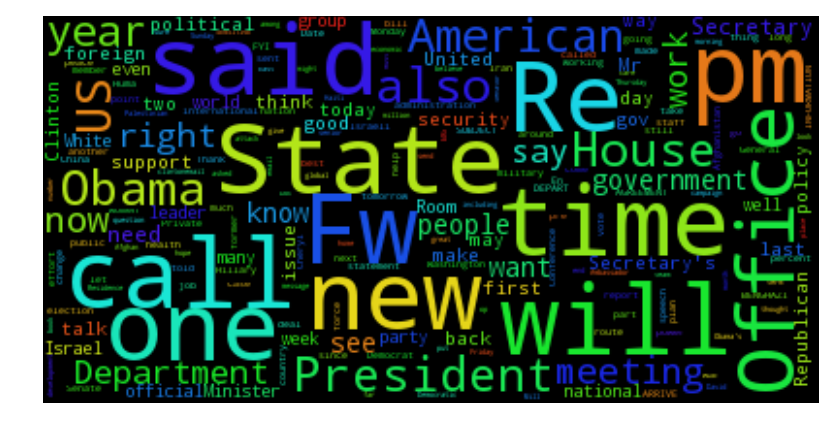

In [37]:
classic_cloud(text)

Not bad.